In [1]:
import sys
sys.path.append('../')

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
#get data = 
path ="../data/raw/economatica.xlsx"

In [61]:
df = pd.read_excel(path).dropna()
df.drop(index=df.loc[df["SP500"]== "-"].index,inplace=True)
df = df[df["Data"]>="2009-01-01"].loc[:,["Data","SP500"]].reset_index(drop=True)
df["SP500"] = df["SP500"].astype(float)

In [67]:
spNormalReturns = df["SP500"].pct_change()
spLogReturns = np.log(1+spNormalReturns)

In [96]:
MeanLogReturns = np.array(spLogReturns.mean())
VarLogReturns = np.array(spLogReturns.var()) 
StdevLogReturns = np.array(spLogReturns.std()) 


In [97]:
Drift = MeanLogReturns - (0.5 * VarLogReturns)
print("Drift = ",Drift)

Drift =  0.00034278028889976093


In [98]:
NumIntervals = len(df)

Iterations = 20

np.random.seed(7)
SBMotion = norm.ppf(np.random.rand(NumIntervals, Iterations))

In [99]:
DailyReturns = np.exp(Drift + StdevLogReturns*SBMotion)

In [100]:
StartStockPrices = df["SP500"].iloc[0]

In [101]:
StockPrice = np.zeros_like(DailyReturns)

In [102]:
StockPrice[0] = StartStockPrices

In [103]:
for t in range(1, NumIntervals):
  StockPrice[t] = StockPrice[t-1]*DailyReturns[t]

In [108]:
spTrend = np.array(df.iloc[:,1])

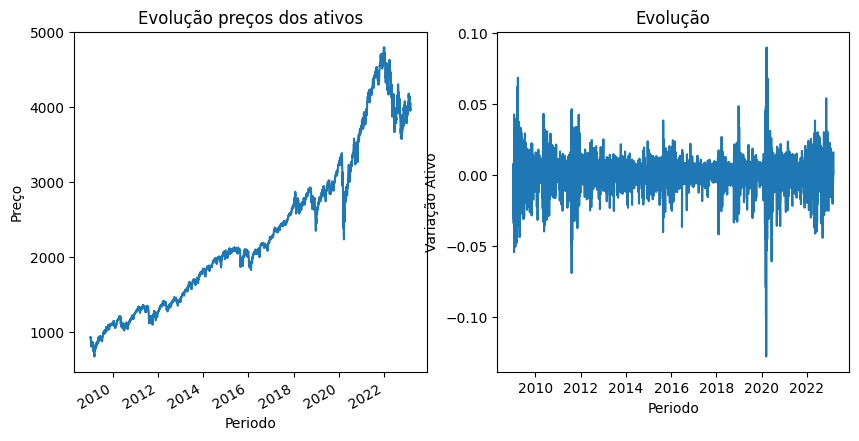

In [123]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

df.plot(
    kind="line",
    x="Data",
    y="SP500",
    xlabel="Periodo",
    ylabel="Preço",
    legend=False,
    title="Evolução preços dos ativos",
    ax=axes[0]
)

axes[1].plot(
  df["Data"],
  spLogReturns
)
axes[1].set(xlabel="Periodo",ylabel="Variação Ativo",title="Evolução")
fig.tight_layout;


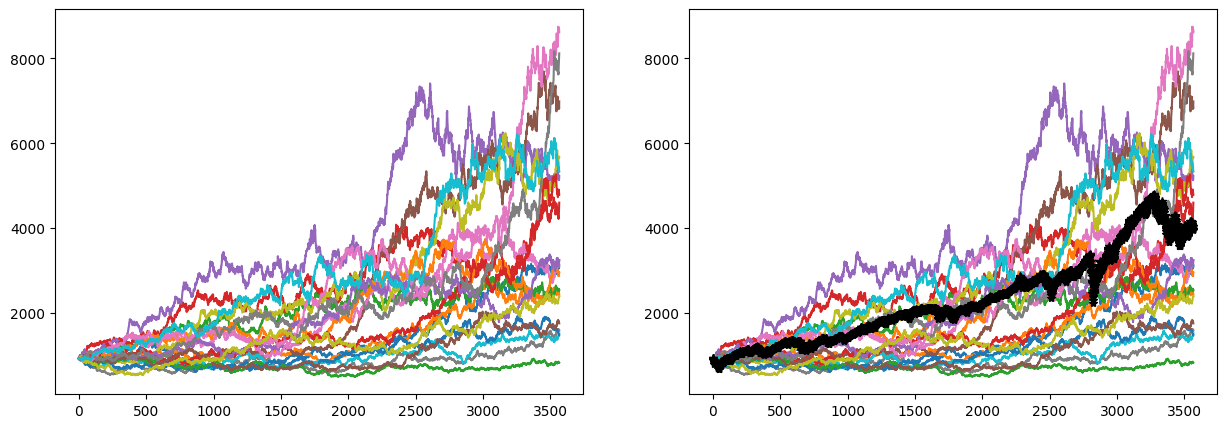

In [125]:
fig,axes = plt.subplots(1,2,figsize=(15,5))

axes[0].plot(
    StockPrice
);

axes[1].plot(
    StockPrice
);

axes[1].plot()
axes[1].plot(spTrend,'k*');
